In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd

# Damage to Financial Services and Points of Tourism

Points of Interest data were obtained from [OSM](https://data.humdata.org/dataset/hotosm_mar_points_of_interest?) and Earthquake Intensity files were taken from [USGS](https://www.usgs.gov/). These data were juxtaposed to identify the buildings that would have seen the most amount of damage. Only the regions with earthquake intesnity on the mmi scale >7 are considered within this analysis.


## Assumptions & Limitations

Data from OpenStreetMaps is crowdsourced and is not frequently updated. Therefore, the points identified may be wrongly counted in some locations. The assumption made is that any area which withstood earthquke intensity greater than 7 on the mmi scale would have taken damage. 


## Findings

In [2]:
#settlement = gpd.read_file('../../data/population/atlasAI/AtlasAI_AHS_Morocco_2022_Built_Up_Settlement_Map.geojson')

In [23]:
morocco_adm2 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_2.shp')
morocco_adm1 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_1.shp')
morocco_adm4= gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_4.shp')
morocco_adm3 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_3.shp')

In [4]:
mi_sep8 = gpd.read_file('../../data/earthquake/shape/mi.shp')

In [5]:
affected_regions = mi_sep8[mi_sep8['PARAMVALUE']>=7]

In [43]:
affected_adm1 = ['Souss - Massa - Draâ', 'Marrakech - Tensift - Al Haouz']
affected_morocco_adm1 = morocco_adm1[morocco_adm1['NAME_1'].isin(affected_adm1)]
affected_adm2 = morocco_adm2[morocco_adm2['NAME_1'].isin(affected_adm1)]
affected_adm3 = morocco_adm3[morocco_adm3['NAME_1'].isin(affected_adm1)]
affected_adm4 = morocco_adm4.sjoin(affected_regions)

In [73]:
financial_services = gpd.read_file('../../data/poi/hotosm_mar_financial_services_points_shp_shp_uid_36a0ca17-0d63-4977-8063-786fc7a6bf87/hotosm_mar_financial_services_points_shp_point.shp')
poi = gpd.read_file('../../data/poi/hotosm_mar_points_of_interest_points_shp_shp_uid_e08eeee9-52cf-4439-b4d5-a5a5b70d9e94/hotosm_mar_points_of_interest_points_shp_point.shp')
tourist_attractions = poi[~(poi['tourism'].isnull())]
#financial_services = financial_services.sjoin(affected_morocco_adm1)

In [26]:
financial_services_list = list(financial_services['amenity'].unique())

In [27]:
percent_financial_services_in_affected_region = round(100*len(affected_regions.sjoin(financial_services)['osm_id'].unique())/len(financial_services['osm_id'].unique()),2)
number_financial_services_in_affected_region = len(affected_regions.sjoin(financial_services)['osm_id'].unique())
print(f'{percent_financial_services_in_affected_region}% (i.e., {number_financial_services_in_affected_region}) of financial services across the country are in the regions affected by the earthquake. These services include {financial_services_list}')

0.45% (i.e., 17) of financial services across the country are in the regions affected by the earthquake. These services include ['bank', 'post_office', 'bureau_de_change', 'atm', 'money_transfer']


In [79]:
poi_in_morocco = list(morocco_adm1.sjoin(financial_services)['osm_id'].unique())
financial_services = financial_services[financial_services['osm_id'].isin(poi_in_morocco)]
affected_financial_services = list(affected_regions.sjoin(financial_services)['osm_id'].unique())

In [48]:
population_adm4 = pd.read_csv('../../data/population/hrsl/morocco_processed/hrsl_morocco_adm4.csv')
children_adm4 = pd.read_csv('../../data/population/hrsl/morocco_processed/hrsl_morocco_children_adm4.csv')
population_adm4 = population_adm4.merge(children_adm4)
population_adm4.drop(columns = 'Unnamed: 0', inplace= True)

In [54]:
affected_population_adm4 = affected_adm4.merge(population_adm4)[['NAME_1', 'NAME_2', 'NAME_3', 'NAME_4', 'mar_general_2020', 'mar_children_under_five_2020', 'geometry']]
affected_population_adm4['population_without_children'] = affected_population_adm4['mar_general_2020'] - affected_population_adm4['mar_children_under_five_2020']

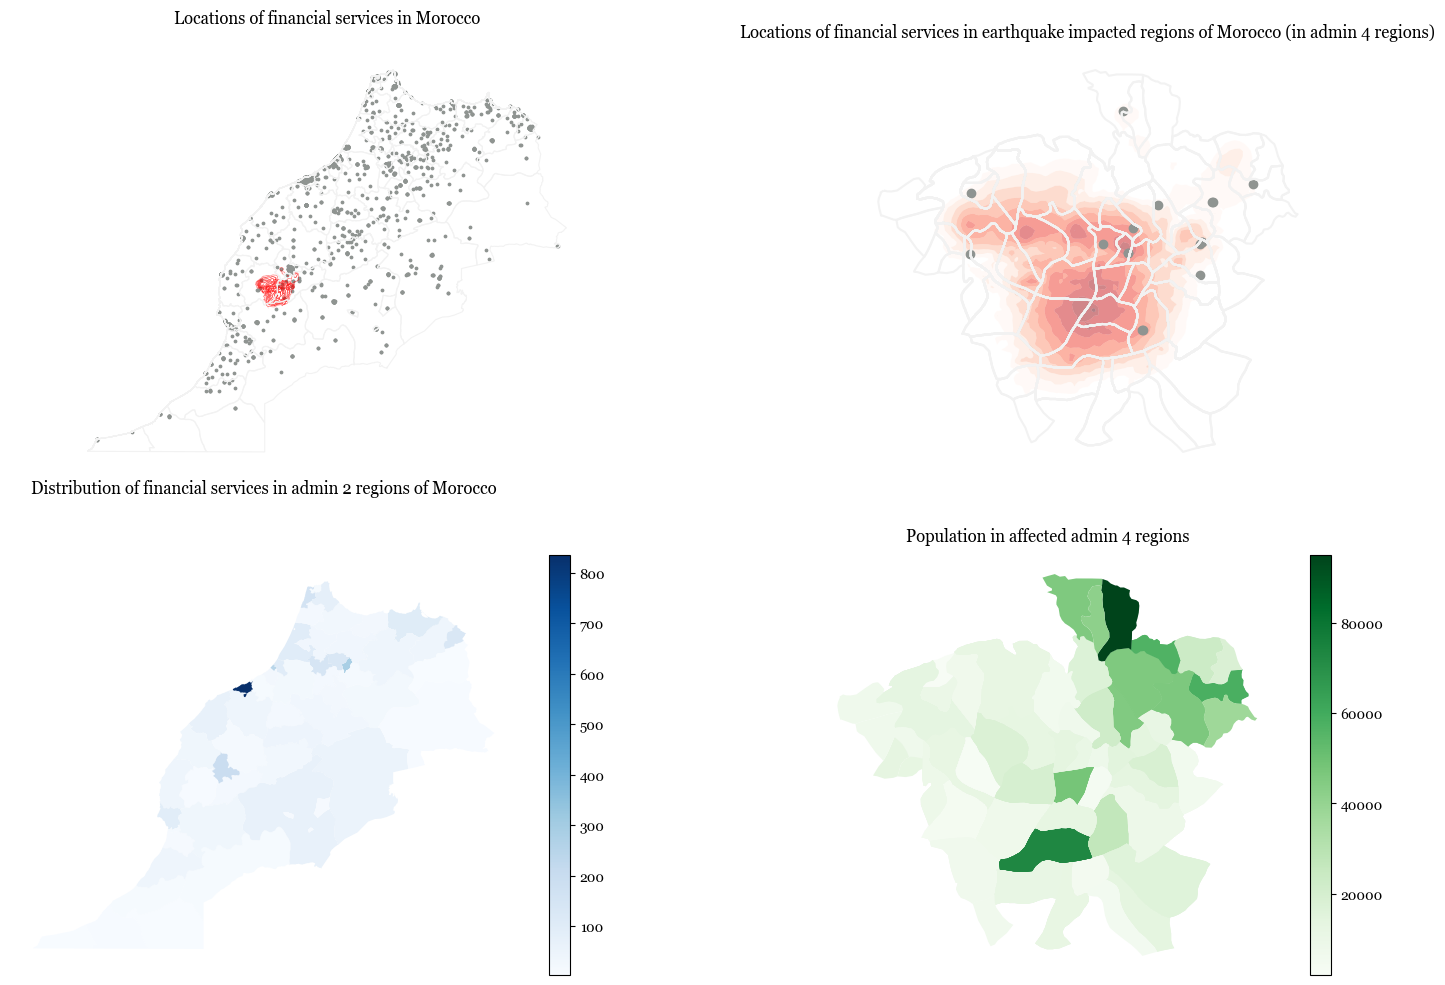

In [133]:
import matplotlib.pyplot as plt
import matplotlib

fig, axs = plt.subplots(2,2, figsize = (18,12))
ax = axs.flatten()

matplotlib.rcParams['font.family'] = 'Georgia'

affected_regions.boundary.plot(ax=ax[0], color = 'red', linewidth = 0.5, alpha = 0.5)
financial_services.plot(ax=ax[0], color = '#8F9491', markersize = 3)
morocco_adm2.boundary.plot(color = '#f2f2f2', ax=ax[0], linewidth = 0.8)
ax[0].set_title('Locations of financial services in Morocco', pad=20, fontsize = 12)
ax[0].axis('off')

morocco_adm4.sjoin(affected_regions).boundary.plot(ax=ax[1], color = '#f2f2f2')
affected_regions.plot(column = 'PARAMVALUE', ax=ax[1], cmap = 'Reds', alpha = 0.5)
financial_services[financial_services['osm_id'].isin(affected_financial_services)].plot(ax=ax[1], color = '#8F9491')
ax[1].set_title('Locations of financial services in earthquake impacted regions of Morocco (in admin 4 regions)', pad=10, fontsize = 12)
ax[1].axis('off')

financial_services_adm2 = morocco_adm2.sjoin(financial_services).groupby(['NAME_2']).count()[['osm_id']].reset_index()
morocco_adm2.merge(financial_services_adm2).plot(column = 'osm_id', legend = True,  ax = ax[2], cmap = 'Blues')
ax[2].set_title('Distribution of financial services in admin 2 regions of Morocco', pad = 50, fontsize = 12)
#ax[2].legend(loc = 'center left', bbox_to_anchor=(1,0.5))

ax[2].axis('off')

affected_population_adm4.plot(column = 'population_without_children', legend = True, ax=ax[3], cmap = 'Greens')
ax[3].set_title('Population in affected admin 4 regions', pad=10, fontsize = 12)
ax[3].axis('off');

In [124]:
financial_services['affected'] = financial_services['osm_id'].apply(lambda x:get_affected(x, affected_financial_services))
financial_services_adm4 = morocco_adm4.sjoin(financial_services)
financial_services_adm2 = morocco_adm2.sjoin(financial_services)

financial_services_adm2 = financial_services_adm2.groupby(['NAME_1', 'NAME_2']).agg({'osm_id':'count', 'affected':'sum'}).reset_index()
financial_services_adm2['percent_affected'] = 100*financial_services_adm2['affected']/financial_services_adm2['osm_id']

financial_services_adm2[financial_services_adm2['percent_affected']>0]

,NAME_1,NAME_2,osm_id,affected,percent_affected
18,Marrakech - Tensift - Al Haouz,Al Haouz,21,14,66.666667
19,Marrakech - Tensift - Al Haouz,Chichaoua,7,2,28.571429
22,Marrakech - Tensift - Al Haouz,Marrakech,196,1,0.510204


In [74]:
tourist_attractions_in_morocco = list(morocco_adm1.sjoin(tourist_attractions)['osm_id'].unique())
tourist_attractions = tourist_attractions[tourist_attractions['osm_id'].isin(tourist_attractions_in_morocco)]
affected_tourist_attractions = list(affected_regions.sjoin(tourist_attractions)['osm_id'].unique())
tousit_attraction_list = tourist_attractions['tourism'].unique()

In [68]:
percent_tourist_attractions_in_affected_region = round(100*len(affected_regions.sjoin(tourist_attractions)['osm_id'].unique())/len(tourist_attractions['osm_id'].unique()),2)
number_tourist_attractions_in_affected_region = len(affected_regions.sjoin(tourist_attractions)['osm_id'].unique())
print(f'{percent_tourist_attractions_in_affected_region}% (i.e., {number_tourist_attractions_in_affected_region}) of tourist attractions across the country are in the regions affected by the earthquake. These services include {tousit_attraction_list}')

1.33% (i.e., 74) of tourist attractions across the country are in the regions affected by the earthquake. These services include ['viewpoint' 'attraction' 'camp_site' 'guest_house' 'information' 'hotel'
 'artwork' 'caravan_site' 'hostel' 'yes' 'museum' 'apartment' 'motel'
 'alpine_hut' 'chalet' 'camp_pitch' 'picnic_site' 'theme_park'
 'wilderness_hut' 'gallery' 'zoo' 'hotel;camping' 'camp_site;hotel'
 'hotel;camp_site' 'monument' 'lean_to' 'guest_house;hotel;camp_site'
 'wiewpoint' 'cascade' 'guest_house;hotel' 'water_point' 'spa_resort'
 'guest_house;camp_site']


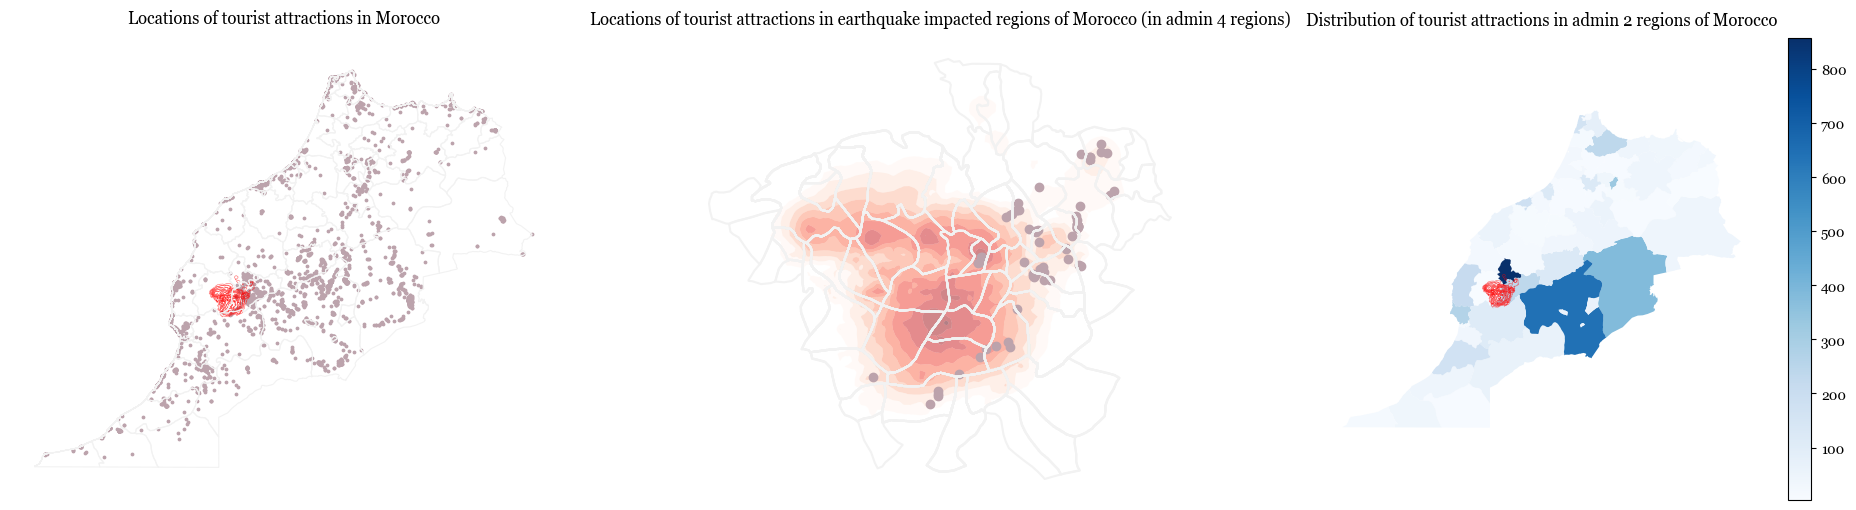

In [132]:
import matplotlib.pyplot as plt
import matplotlib

fig, axs = plt.subplots(1,3, figsize = (24,6))
ax = axs.flatten()

matplotlib.rcParams['font.family'] = 'Georgia'

affected_regions.boundary.plot(ax=ax[0], color = 'red', linewidth = 0.5, alpha = 0.5)
tourist_attractions.plot(ax=ax[0], color = '#BCA3AC', markersize = 3)
morocco_adm2.boundary.plot(color = '#f2f2f2', ax=ax[0], linewidth = 0.8)
ax[0].set_title('Locations of tourist attractions in Morocco', pad=20, fontsize = 12)
ax[0].axis('off')

morocco_adm4.sjoin(affected_regions).boundary.plot(ax=ax[1], color = '#f2f2f2')
affected_regions.plot(column = 'PARAMVALUE', ax=ax[1], cmap = 'Reds', alpha = 0.5)
tourist_attractions[tourist_attractions['osm_id'].isin(affected_tourist_attractions)].plot(ax=ax[1], color = '#BCA3AC')
ax[1].set_title('Locations of tourist attractions in earthquake impacted regions of Morocco (in admin 4 regions)', pad=10, fontsize = 12)
ax[1].axis('off')

affected_regions.boundary.plot(ax=ax[2], color = 'red', linewidth = 0.5, alpha = 0.5)
tourist_attractions_adm2 = morocco_adm2.sjoin(tourist_attractions).groupby(['NAME_2']).count()[['osm_id']].reset_index()
morocco_adm2.merge(tourist_attractions_adm2).plot(column = 'osm_id', legend = True,  ax = ax[2], cmap = 'Blues')
ax[2].set_title('Distribution of tourist attractions in admin 2 regions of Morocco', pad = 50, fontsize = 12)

ax[2].axis('off');

In [122]:
def get_affected(value, affected_list):
    if value in affected_list:
        return 1
    else:
        return 0

In [113]:
tourist_attractions['affected'] = tourist_attractions['osm_id'].apply(lambda x:get_affected(x, affected_tourist_attractions))
tourist_attractions_adm4 = morocco_adm4.sjoin(tourist_attractions)
tourist_attractions_adm2 = morocco_adm2.sjoin(tourist_attractions)

In [118]:
tourist_attractions_adm2 = tourist_attractions_adm2.groupby(['NAME_1', 'NAME_2']).agg({'osm_id':'count', 'affected':'sum'}).reset_index()
tourist_attractions_adm2['percent_affected'] = 100*tourist_attractions_adm2['affected']/tourist_attractions_adm2['osm_id']

In [121]:
tourist_attractions_adm2[tourist_attractions_adm2['percent_affected']>0]

,NAME_1,NAME_2,osm_id,affected,percent_affected
18,Marrakech - Tensift - Al Haouz,Al Haouz,237,68,28.691983
19,Marrakech - Tensift - Al Haouz,Chichaoua,5,1,20.000000
22,Marrakech - Tensift - Al Haouz,Marrakech,857,1,0.116686
41,Souss - Massa - Draâ,Taroudannt,112,4,3.571429


In [20]:
percentage_tourist_damages = {}
for admin2 in affected_admin2:
    percentage_tourist_damages[admin2]=dict(100*tourist_attractions_adm2[tourist_attractions_adm2['NAME_2']==admin2].groupby('affected').size()/tourist_attraction_adm2[admin2])

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/c5888cbb-e1e8-4844-b80f-178cda333a17/embed" frameborder="0" allowfullscreen></iframe>